In [1]:
import numpy as np
import pandas as pd
import os
import glob
from sklearn.preprocessing import StandardScaler

In [2]:
def calculate_joint_angle(p1, p2, p3):
    """Calculates the angle (in degrees) at vertex p2."""
    vec1 = p1 - p2
    vec2 = p3 - p2
    angle = np.degrees(np.arctan2(vec2[:, 1], vec2[:, 0]) - np.arctan2(vec1[:, 1], vec1[:, 0]))
    angle = np.abs(angle % 360)
    # Ensure the angle is the smaller one (<= 180)
    mask = angle > 180
    angle[mask] = 360 - angle[mask]
    return angle

In [3]:
def extract_features(df):

    coord_cols = [col for col in df.columns if col.endswith('_x') or col.endswith('_y')]
    parts = sorted(set(c.rsplit('_', 1)[0] for c in coord_cols))

    # GET VELOCITY AND ACCELERATION
    vel, acc = {}, {}
    for part in parts:
        x = df[f"{part}_x"]
        y = df[f"{part}_y"]
        dx = x.diff()
        dy = y.diff()
        speed = np.sqrt(dx**2 + dy**2)
        vel[f"{part}_speed"] = speed

        ddx = dx.diff()
        ddy = dy.diff()
        accel = np.sqrt(ddx**2 + ddy**2)
        acc[f"{part}_accel"] = accel
        
    vel_df = pd.DataFrame(vel)
    acc_df = pd.DataFrame(acc)
    vel_df = vel_df.fillna(0)
    acc_df = acc_df.fillna(0)

    # get relevant velocities 
    vel_useful = ['left_ankle_speed', 'left_elbow_speed', 'left_knee_speed',
              'left_wrist_speed', 'nose_speed', 'right_ankle_speed', 
              'right_elbow_speed', 'right_knee_speed', 'right_wrist_speed',
              'left_shoulder_speed', 'right_shoulder_speed']
    vel_df = vel_df[vel_useful]

    # get relevant accelerations
    acc_useful = ['left_ankle_accel', 'left_elbow_accel', 'left_knee_accel',
              'left_wrist_accel', 'nose_accel', 'right_ankle_accel', 
              'right_elbow_accel', 'right_knee_accel', 'right_wrist_accel',
              'left_shoulder_accel', 'right_shoulder_accel']
    acc_df = acc_df[acc_useful]

    # GET DISTANCE 
    dist = {}
    for i in range(len(parts)):
        for j in range(i + 1, len(parts)):
            p1, p2 = parts[i], parts[j]
            dx = df[f"{p1}_x"] - df[f"{p2}_x"]
            dy = df[f"{p1}_y"] - df[f"{p2}_y"]
            dist[f"dist_{p1}_{p2}"] = np.sqrt(dx**2 + dy**2)
    
    dist_df = pd.DataFrame(dist)

    dist_useful = ['dist_left_eye_left_wrist', 'dist_right_eye_right_wrist', 
               'dist_right_knee_right_wrist', 'dist_left_knee_left_wrist',
               'dist_right_elbow_right_knee', 'dist_left_elbow_left_knee',
               'dist_right_knee_right_shoulder', 'dist_left_knee_left_shoulder']
    
    dist_df = dist_df[dist_useful]

    # GET ANGLES
    # Basic Joint Angles
    angle_definitions = {
        'left_elbow': ['left_shoulder', 'left_elbow', 'left_wrist'],
        'right_elbow': ['right_shoulder', 'right_elbow', 'right_wrist'],
        'left_shoulder': ['left_elbow', 'left_shoulder', 'left_hip'],
        'right_shoulder': ['right_elbow', 'right_shoulder', 'right_hip'],
        'left_hip': ['left_shoulder', 'left_hip', 'left_knee'],
        'right_hip': ['right_shoulder', 'right_hip', 'right_knee'],
        'left_knee': ['left_hip', 'left_knee', 'left_ankle'],
        'right_knee': ['right_hip', 'right_knee', 'right_ankle']
    }
    angle_df = {}
    for name, joints in angle_definitions.items():
        p1 = df[[f'{joints[0]}_x', f'{joints[0]}_y']].values
        p2 = df[[f'{joints[1]}_x', f'{joints[1]}_y']].values
        p3 = df[[f'{joints[2]}_x', f'{joints[2]}_y']].values
        angle_df[f'{name}_angle'] = calculate_joint_angle(p1, p2, p3)

    angle_df = pd.DataFrame(angle_df)

    extracted_features = pd.concat([vel_df, acc_df, dist_df, angle_df], axis=1)
  
    return extracted_features
    

In [4]:

def load_subject_data(file_pattern):
    
    csv_files = glob.glob(file_pattern)
    if not csv_files:
        print(f"Error: No files found for pattern '{file_pattern}'.")

    all_dfs = []
    for i, f in enumerate(csv_files):
        df = pd.read_csv(f)
        df['subject'] = os.path.splitext(os.path.basename(csv_files[i]))[0]

        #  PREPROCESSING
        df['label'] = df['label'].fillna('label_nan')
        df['label'] = df['label'].replace('Throwing', 'Throwing things')

        # remove negatives
        df = df[(df.select_dtypes(include=[np.number]) >= 0).all(axis=1)]

        # remove anomalies using z-score
        coords_columns = [col for col in df.columns if col.endswith('_x') or col.endswith('_y')]
        z_scores = ((df[coords_columns] - df[coords_columns].mean()) / df[coords_columns].std()).abs()
        outliers = (z_scores > 4).any(axis=1)   
        outlier_rows = df[outliers]
        outlier_indices = outlier_rows.index.tolist()   # Get rows index where outliers is True
        df_no_anomalies = df.drop(index=outlier_indices)
        df_no_anomalies.reset_index(inplace=True, drop=True)

        # extract features and remove anomalies
        extracted_features = extract_features(df_no_anomalies)

        z_features = ((extracted_features.select_dtypes(include=[np.number]) -
               extracted_features.select_dtypes(include=[np.number]).mean()) /
               extracted_features.select_dtypes(include=[np.number]).std()).abs()
        anomalies = (z_features > 4).any(axis=1)
        anomalies_rows = extracted_features[anomalies]
        anomalies_index = anomalies_rows.index.tolist()
        extracted_features_no_anomalies = extracted_features.drop(index = anomalies_index)
        
        df_no_anomalies = df_no_anomalies.drop(index = anomalies_index)
        
        # reset index
        df_no_anomalies.reset_index(inplace=True, drop=True)
        extracted_features_no_anomalies.reset_index(inplace=True, drop=True)

        # merge all features
        final_df = pd.concat([df_no_anomalies.drop(columns=['label', 'subject']), extracted_features_no_anomalies, df_no_anomalies[['label', 'subject']]], axis=1)

        # scale each df separately
        feature_columns = final_df.columns.difference(['frame_id', 'label', 'subject'])
        ss = StandardScaler()
        sub_scaled = final_df.copy()
        sub_scaled[feature_columns] = ss.fit_transform(final_df[feature_columns])
        all_dfs.append(sub_scaled)

    master_df = pd.concat(all_dfs, ignore_index=True)

    return master_df

In [5]:
file_pattern = r'D:\pr_env\py_env\Scripts\keypointlabel\*.csv'
df = load_subject_data(file_pattern)
df

,frame_id,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,left_elbow_angle,right_elbow_angle,left_shoulder_angle,right_shoulder_angle,left_hip_angle,right_hip_angle,left_knee_angle,right_knee_angle,label,subject
0,0,0.582216,-1.433003,0.600550,-1.450621,0.638912,-1.453942,0.792782,-1.452541,1.045688,...,0.991116,0.648909,-1.611763,-0.998619,0.916058,1.165615,1.014976,0.887830,Walking,keypoints_with_labels_1
1,1,0.536367,-1.415514,0.551222,-1.432965,0.589596,-1.435332,0.744464,-1.430306,0.994283,...,1.113083,0.689997,-1.526466,-1.042054,0.893764,1.144316,1.004778,0.872147,Walking,keypoints_with_labels_1
2,2,0.486697,-1.410516,0.501894,-1.425398,0.547868,-1.429129,0.692428,-1.413303,0.964908,...,1.216949,0.785944,-1.377405,-1.150079,0.920036,1.061935,1.036170,0.867893,Walking,keypoints_with_labels_1
3,3,0.429386,-1.405519,0.448771,-1.420354,0.490966,-1.424167,0.644110,-1.413303,0.906160,...,1.258259,0.767135,-1.228014,-0.966514,0.967060,0.982690,1.036063,0.848313,Walking,keypoints_with_labels_1
4,4,0.383536,-1.415514,0.407032,-1.425398,0.449238,-1.431610,0.588358,-1.405456,0.862099,...,1.260143,0.799125,-1.062484,-0.871808,1.065320,0.937009,0.987234,0.804975,Walking,keypoints_with_labels_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321324,76052,1.276114,-1.542140,1.269384,-1.563141,1.263228,-1.574082,1.142107,-1.563749,1.097289,...,0.913243,0.962667,-1.073924,0.283609,1.565123,1.533675,1.462770,0.835026,label_nan,keypoints_with_labels_5
321325,76055,1.381036,-1.559337,1.368066,-1.575277,1.381629,-1.592068,1.238003,-1.595061,1.200774,...,0.558600,0.832826,-1.130063,0.313564,1.481543,1.553141,1.551907,0.818197,label_nan,keypoints_with_labels_5
321326,76056,1.418067,-1.559337,1.401988,-1.575277,1.421096,-1.595494,1.265402,-1.587904,1.234797,...,0.620110,0.823520,-1.056570,0.231183,1.419772,1.382683,1.498442,0.794417,label_nan,keypoints_with_labels_5
321327,76059,1.547677,-1.566215,1.528425,-1.588279,1.548604,-1.602346,1.353687,-1.604902,1.359547,...,0.418058,0.849030,-1.217657,-0.065135,1.383269,1.125988,1.564491,1.076767,label_nan,keypoints_with_labels_5


In [6]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['label'] = le.fit_transform(df['label'])
labels = le.classes_
codes = le.transform(labels)
label_map = dict(zip(labels, codes))
label_map

{'Attacking': 0,
 'Biting': 1,
 'Eating snacks': 2,
 'Head banging': 3,
 'Sitting quietly': 4,
 'Throwing things': 5,
 'Using phone': 6,
 'Walking': 7,
 'label_nan': 8}

In [7]:
X = df.iloc[:, 1:-2]
y = df.iloc[:, -2]
s = df.iloc[:, -1]

In [8]:
def create_sequences_by_activity(X, y, s, sequence_length, step_size):
   
    sequences = []
    labels = []
    subjects = []

    # Find the indices where the activity changes
    # A change occurs where the current label is different from the previous one
    # .shift() moves the index down by one, allowing for comparison
    activity_change_indices = y[y != y.shift()].index

    # Create a list of the start and end indices for each continuous segment
    # We add the start (0) and end (len(y)) of the entire dataset
    segment_boundaries = sorted(list(set([0] + activity_change_indices.tolist() + [len(y)])))

    print(f"Found {len(segment_boundaries) - 1} distinct activity segments.")

    # Iterate over each identified activity segment
    for i in range(len(segment_boundaries) - 1):
        start_idx = segment_boundaries[i]
        end_idx = segment_boundaries[i+1]
        
        # Extract the data for the current segment
        segment_X = X.iloc[start_idx:end_idx]
        segment_y = y.iloc[start_idx:end_idx]
        segment_s = s.iloc[start_idx:end_idx]

        # All labels in this segment are the same, so we can just take the first one
        activity_label = segment_y.iloc[0]
        subject = segment_s.iloc[0]

        # Ensure the segment is long enough to create at least one sequence
        if len(segment_X) >= sequence_length:
            # Create all possible overlapping windows within this clean segment
            for j in range(0, len(segment_X) - sequence_length + 1, step_size):
                sequences.append(segment_X.iloc[j:j + sequence_length].values)
                labels.append(activity_label)
                subjects.append(subject)
    
    print(f"Total sequences created: {len(sequences)}")
    return np.array(sequences), np.array(labels), np.array(subjects)


In [9]:
sequence_length = 90
step_size = 45
sequences, labels, subject_ids = create_sequences_by_activity(X, y, s, sequence_length, step_size)

Found 131 distinct activity segments.
Total sequences created: 6949


In [10]:
sequences.shape, labels.shape, subject_ids.shape

((6949, 90, 72), (6949,), (6949,))

In [11]:
inv_label_map = {v: k for k, v in label_map.items()} # For visualization later
inv_label_map

{0: 'Attacking',
 1: 'Biting',
 2: 'Eating snacks',
 3: 'Head banging',
 4: 'Sitting quietly',
 5: 'Throwing things',
 6: 'Using phone',
 7: 'Walking',
 8: 'label_nan'}

In [12]:
FEATURE_COLUMNS = df.columns.difference(['frame_id', 'label', 'subject'])
num_classes = len(label_map)
num_classes

9

In [13]:
from tensorflow.keras.utils import to_categorical
y_cat = to_categorical(labels)

In [14]:
from sklearn.utils.class_weight import compute_class_weight

# labels = original labels before one-hot encoding (flattened list)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights_dict = dict(enumerate(class_weights_array))


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, GRU, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

loss = CategoricalCrossentropy(label_smoothing=0.1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)  # (sequence_length, num_features)
    
    x = LSTM(64, return_sequences=True)(inputs)
    # x = Attention()(x)  # Output shape: (batch_size, 256)
    x = Dropout(0.3)(x)

    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(0.3)(x)

    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.2)(x)

    x = Dense(32, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(loss=loss, #'sparse_categorical_crossentropy',
                  optimizer=Adam(0.0001),
                  metrics=['accuracy'])
    return model


In [16]:
BATCH_SIZE = 16
EPOCHS = 50

In [17]:
# === LOSO Cross-validation ===
unique_subjects = np.unique(subject_ids)
unique_subjects


array(['keypoints_with_labels_1', 'keypoints_with_labels_2',
       'keypoints_with_labels_3', 'keypoints_with_labels_5'], dtype='<U23')

In [18]:
test_subject = 'keypoints_with_labels_2'


 Testing on subject keypoints_with_labels_2
Epoch 1/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 50s 134ms/step - accuracy: 0.2351 - loss: 2.1424 - val_accuracy: 0.4917 - val_loss: 1.8517 - learning_rate: 1.0000e-04
Epoch 2/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 43s 139ms/step - accuracy: 0.5015 - loss: 1.5817 - val_accuracy: 0.6404 - val_loss: 1.3835 - learning_rate: 1.0000e-04
Epoch 3/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - accuracy: 0.6937 - loss: 1.2926 - val_accuracy: 0.7138 - val_loss: 1.1586 - learning_rate: 1.0000e-04
Epoch 4/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.7956 - loss: 1.0810 - val_accuracy: 0.6954 - val_loss: 1.0668 - learning_rate: 1.0000e-04
Epoch 5/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 86s 170ms/step - accuracy: 0.8395 - loss: 1.0102 - val_accuracy: 0.7523 - val_loss: 0.8765 - learning_rate: 1.0000e-04
Epoch 6/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - accuracy: 0.8780 - loss: 0.9499 - val_accuracy: 0.7468 - val_loss: 1.0412 - learning_rate: 1.0000e-04
E

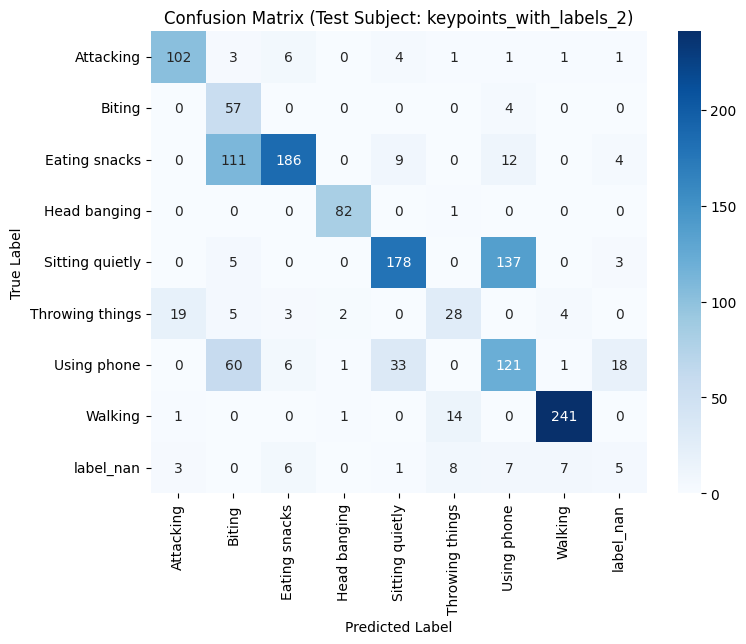

In [19]:

# for test_subject in unique_subjects:
print(f"\n Testing on subject {test_subject}")
train_idx = subject_ids != test_subject
test_idx = subject_ids == test_subject

X_train, y_train = sequences[train_idx], y_cat[train_idx] #label[train_idx]
X_test, y_test = sequences[test_idx], y_cat[test_idx] #label[test_idx]

model = build_model(X_train.shape[1:], num_classes)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stop, lr_scheduler], verbose=1, class_weight=class_weights_dict )

preds = np.argmax(model.predict(X_test), axis=1)
true = np.argmax(y_test, axis=1)
# true = y_test
acc = accuracy_score(true, preds)
f1 = f1_score(true, preds, average='weighted')
print(f"✅ Accuracy: {acc:.2f} | F1 Score: {f1:.2f}")

cm = confusion_matrix(true, preds)
class_names = [inv_label_map[i] for i in range(len(inv_label_map))]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix (Test Subject: {test_subject})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# results.append(acc)
    

In [ ]:
# model.save('best_model.keras')

In [21]:
# test data loading
test_df = pd.read_csv(r'D:\pr_env\py_env\Scripts\keypoint_test_data\test data_keypoint.csv')
test_df

,frame_id,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0,630.5,420.500,638.5,413.000,621.5,413.500,649.5,419.250,610.0,...,611.5,557.50,702.0,581.5,567.0,595.5,618.0,602.0,654.0,608.0
1,1,629.5,421.750,637.5,414.000,620.5,414.500,648.5,420.250,609.0,...,611.5,558.00,702.0,581.5,567.0,595.5,618.0,601.5,654.5,608.0
2,2,629.0,423.250,637.0,415.500,620.0,416.000,648.0,421.000,608.0,...,612.0,557.00,702.0,581.0,567.0,595.0,616.5,601.0,654.5,608.5
3,3,628.5,424.250,636.5,416.500,619.5,417.250,647.0,421.500,607.0,...,612.0,556.00,702.0,580.5,567.0,594.0,617.0,601.5,653.5,608.5
4,4,628.5,425.750,636.0,417.750,619.0,418.750,646.0,422.500,606.5,...,612.5,555.50,702.0,580.0,567.0,593.0,616.5,601.5,651.5,609.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117916,117916,571.5,215.750,580.5,205.625,560.5,207.250,594.0,208.625,546.5,...,569.0,425.75,641.0,519.5,587.0,522.5,660.0,614.0,602.0,599.0
117917,117917,572.0,215.625,581.5,205.375,561.0,207.000,595.0,209.000,547.0,...,570.0,425.00,642.0,518.0,587.5,521.5,660.5,614.0,602.0,599.0
117918,117918,573.0,215.000,582.0,205.125,562.0,206.625,596.0,209.250,548.0,...,570.5,425.25,643.0,518.0,588.0,522.0,661.5,615.0,602.0,599.5
117919,117919,574.0,214.750,583.0,204.875,563.0,206.375,597.0,209.000,549.0,...,570.5,425.50,643.0,517.5,588.0,522.0,663.0,615.0,602.0,599.0


In [22]:
test_df

,frame_id,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0,630.5,420.500,638.5,413.000,621.5,413.500,649.5,419.250,610.0,...,611.5,557.50,702.0,581.5,567.0,595.5,618.0,602.0,654.0,608.0
1,1,629.5,421.750,637.5,414.000,620.5,414.500,648.5,420.250,609.0,...,611.5,558.00,702.0,581.5,567.0,595.5,618.0,601.5,654.5,608.0
2,2,629.0,423.250,637.0,415.500,620.0,416.000,648.0,421.000,608.0,...,612.0,557.00,702.0,581.0,567.0,595.0,616.5,601.0,654.5,608.5
3,3,628.5,424.250,636.5,416.500,619.5,417.250,647.0,421.500,607.0,...,612.0,556.00,702.0,580.5,567.0,594.0,617.0,601.5,653.5,608.5
4,4,628.5,425.750,636.0,417.750,619.0,418.750,646.0,422.500,606.5,...,612.5,555.50,702.0,580.0,567.0,593.0,616.5,601.5,651.5,609.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117916,117916,571.5,215.750,580.5,205.625,560.5,207.250,594.0,208.625,546.5,...,569.0,425.75,641.0,519.5,587.0,522.5,660.0,614.0,602.0,599.0
117917,117917,572.0,215.625,581.5,205.375,561.0,207.000,595.0,209.000,547.0,...,570.0,425.00,642.0,518.0,587.5,521.5,660.5,614.0,602.0,599.0
117918,117918,573.0,215.000,582.0,205.125,562.0,206.625,596.0,209.250,548.0,...,570.5,425.25,643.0,518.0,588.0,522.0,661.5,615.0,602.0,599.5
117919,117919,574.0,214.750,583.0,204.875,563.0,206.375,597.0,209.000,549.0,...,570.5,425.50,643.0,517.5,588.0,522.0,663.0,615.0,602.0,599.0


In [23]:
extracted_test_features = extract_features(test_df)
extracted_test_features

,left_ankle_speed,left_elbow_speed,left_knee_speed,left_wrist_speed,nose_speed,right_ankle_speed,right_elbow_speed,right_knee_speed,right_wrist_speed,left_shoulder_speed,...,dist_right_knee_right_shoulder,dist_left_knee_left_shoulder,left_elbow_angle,right_elbow_angle,left_shoulder_angle,right_shoulder_angle,left_hip_angle,right_hip_angle,left_knee_angle,right_knee_angle
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,131.550608,125.101209,150.909841,146.110160,11.114544,12.095984,116.758069,119.580298,46.015227,48.671290
1,0.500000,0.500000,0.000000,0.707107,1.600781,0.500000,1.581139,0.000000,0.500000,0.250000,...,130.469585,124.860923,150.484540,145.260553,10.775173,12.452536,116.902796,118.841319,45.517496,48.250829
2,1.581139,0.500000,0.500000,0.707107,1.581139,0.500000,0.500000,0.500000,0.500000,0.559017,...,128.899428,124.280177,150.660694,145.146296,10.555412,12.937690,117.617119,118.029065,45.766128,48.949997
3,0.707107,0.500000,0.500000,1.000000,1.118034,1.000000,0.500000,1.000000,0.000000,1.030776,...,127.329543,123.847689,149.805967,146.309932,10.411060,12.668596,118.647766,117.510638,46.948208,49.695254
4,0.500000,0.500000,0.500000,0.500000,1.500000,2.236068,1.118034,1.000000,0.500000,0.000000,...,125.615485,123.369364,150.833736,147.232980,10.063688,12.370071,119.063917,116.328728,47.651102,50.543428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117916,1.414214,1.000000,0.500000,4.562072,1.007782,0.500000,0.559017,0.000000,1.118034,0.500000,...,244.536807,249.225300,170.488704,167.234395,16.609834,16.747331,172.634459,176.289151,177.356628,179.445461
117917,0.500000,0.707107,1.802776,4.609772,0.515388,0.000000,0.559017,1.118034,1.802776,0.500000,...,243.561594,247.768541,173.761946,168.611129,16.522107,17.002853,172.772234,175.765420,177.881443,179.681385
117918,1.414214,1.520691,1.000000,4.007805,1.179248,0.500000,0.707107,0.707107,1.346291,0.500000,...,244.049175,247.808394,175.259571,169.508702,17.167104,16.962899,172.468407,175.764029,178.292408,179.987051
117919,1.500000,1.677051,0.500000,3.535534,1.030776,0.500000,0.250000,0.000000,1.677051,1.030776,...,243.939029,246.981907,176.704114,170.401992,17.590304,17.092621,172.487671,176.004538,177.284081,179.973873


In [24]:
final_test_df = pd.concat([test_df, extracted_test_features], axis=1)
final_test_df

,frame_id,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,dist_right_knee_right_shoulder,dist_left_knee_left_shoulder,left_elbow_angle,right_elbow_angle,left_shoulder_angle,right_shoulder_angle,left_hip_angle,right_hip_angle,left_knee_angle,right_knee_angle
0,0,630.5,420.500,638.5,413.000,621.5,413.500,649.5,419.250,610.0,...,131.550608,125.101209,150.909841,146.110160,11.114544,12.095984,116.758069,119.580298,46.015227,48.671290
1,1,629.5,421.750,637.5,414.000,620.5,414.500,648.5,420.250,609.0,...,130.469585,124.860923,150.484540,145.260553,10.775173,12.452536,116.902796,118.841319,45.517496,48.250829
2,2,629.0,423.250,637.0,415.500,620.0,416.000,648.0,421.000,608.0,...,128.899428,124.280177,150.660694,145.146296,10.555412,12.937690,117.617119,118.029065,45.766128,48.949997
3,3,628.5,424.250,636.5,416.500,619.5,417.250,647.0,421.500,607.0,...,127.329543,123.847689,149.805967,146.309932,10.411060,12.668596,118.647766,117.510638,46.948208,49.695254
4,4,628.5,425.750,636.0,417.750,619.0,418.750,646.0,422.500,606.5,...,125.615485,123.369364,150.833736,147.232980,10.063688,12.370071,119.063917,116.328728,47.651102,50.543428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117916,117916,571.5,215.750,580.5,205.625,560.5,207.250,594.0,208.625,546.5,...,244.536807,249.225300,170.488704,167.234395,16.609834,16.747331,172.634459,176.289151,177.356628,179.445461
117917,117917,572.0,215.625,581.5,205.375,561.0,207.000,595.0,209.000,547.0,...,243.561594,247.768541,173.761946,168.611129,16.522107,17.002853,172.772234,175.765420,177.881443,179.681385
117918,117918,573.0,215.000,582.0,205.125,562.0,206.625,596.0,209.250,548.0,...,244.049175,247.808394,175.259571,169.508702,17.167104,16.962899,172.468407,175.764029,178.292408,179.987051
117919,117919,574.0,214.750,583.0,204.875,563.0,206.375,597.0,209.000,549.0,...,243.939029,246.981907,176.704114,170.401992,17.590304,17.092621,172.487671,176.004538,177.284081,179.973873


In [25]:
ss = StandardScaler()
cols = final_test_df.columns.difference(['frame_id'])
scaled_test_df = final_test_df.copy()
scaled_test_df[cols] = ss.fit_transform(final_test_df[cols])
scaled_test_df

,frame_id,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,dist_right_knee_right_shoulder,dist_left_knee_left_shoulder,left_elbow_angle,right_elbow_angle,left_shoulder_angle,right_shoulder_angle,left_hip_angle,right_hip_angle,left_knee_angle,right_knee_angle
0,0,-0.248519,0.736692,-0.224225,0.747038,-0.288084,0.748807,-0.259202,0.867856,-0.389940,...,-0.769947,-0.788219,0.805048,0.773834,-0.755018,-0.527643,-0.800975,-1.121121,-1.071577,-1.149689
1,1,-0.266107,0.746920,-0.241947,0.755201,-0.305243,0.756978,-0.278489,0.876293,-0.406145,...,-0.785248,-0.791456,0.796618,0.758708,-0.780921,-0.501243,-0.796673,-1.148126,-1.079063,-1.156442
2,2,-0.274902,0.759194,-0.250807,0.767444,-0.313822,0.769233,-0.288132,0.882621,-0.422351,...,-0.807473,-0.799280,0.800110,0.756674,-0.797694,-0.465321,-0.775436,-1.177808,-1.075323,-1.145212
3,3,-0.283696,0.767377,-0.259668,0.775607,-0.322402,0.779446,-0.307419,0.886839,-0.438556,...,-0.829694,-0.805106,0.783166,0.777390,-0.808712,-0.485246,-0.744795,-1.196753,-1.057543,-1.133242
4,4,-0.283696,0.779652,-0.268529,0.785810,-0.330982,0.791702,-0.326705,0.895276,-0.446659,...,-0.853956,-0.811550,0.803540,0.793823,-0.835226,-0.507349,-0.732423,-1.239944,-1.046971,-1.119618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117916,117916,-1.286243,-0.938745,-1.252065,-0.945640,-1.334799,-0.936346,-1.329607,-0.909203,-1.418984,...,0.829321,0.884013,1.193162,1.149903,-0.335585,-0.183247,0.860220,0.951191,0.903995,0.950825
117917,117917,-1.277448,-0.939767,-1.234344,-0.947681,-1.326219,-0.938389,-1.310320,-0.906039,-1.410882,...,0.815517,0.864387,1.258048,1.174413,-0.342281,-0.164327,0.864316,0.932052,0.911889,0.954614
117918,117918,-1.259860,-0.944882,-1.225483,-0.949721,-1.309060,-0.941453,-1.291034,-0.903930,-1.394676,...,0.822419,0.864924,1.287736,1.190392,-0.293051,-0.167286,0.855283,0.932001,0.918070,0.959524
117919,117919,-1.242271,-0.946927,-1.207762,-0.951762,-1.291901,-0.943495,-1.271747,-0.906039,-1.378471,...,0.820860,0.853789,1.316371,1.206295,-0.260749,-0.157681,0.855856,0.940790,0.902903,0.959312


In [26]:
X = scaled_test_df.drop(columns=['frame_id'])

In [27]:
# convert to  sequences

def create_sequences(X, seq_len=90, step=45):
    X_seq = []
    for i in range(0, len(X) - seq_len + 1, step):
        X_seq.append(X[i:i+seq_len])
        # y_seq.append(max(set(y[i:i+seq_len]), key=list(y[i:i+seq_len]).count))  # majority label
    return np.array(X_seq)


In [28]:
test_sequences = create_sequences(X)
test_sequences.shape

(2619, 90, 72)

In [29]:
y_test_pred = model.predict(test_sequences)
y_test_pred

82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step


array([[0.01177736, 0.00537169, 0.00403179, ..., 0.00805967, 0.00630618,
        0.02937628],
       [0.01310659, 0.00565047, 0.00435614, ..., 0.00960503, 0.00687559,
        0.03186421],
       [0.01307608, 0.00571918, 0.00436272, ..., 0.0094964 , 0.0068888 ,
        0.03238267],
       ...,
       [0.01938588, 0.04249445, 0.49453545, ..., 0.28318262, 0.05482023,
        0.02464366],
       [0.0241733 , 0.04800273, 0.44701913, ..., 0.03616947, 0.05974036,
        0.0970303 ],
       [0.02829958, 0.0326169 , 0.18816856, ..., 0.01519682, 0.1225823 ,
        0.12137758]], dtype=float32)

In [30]:
test_pred = np.argmax(y_test_pred, axis=1)
test_pred

array([4, 4, 4, ..., 2, 2, 3], dtype=int64)

In [31]:
total_frames = len(test_df)
total_frames

117921

In [32]:
frame_predictions = {i: {'label_prob': -1.0, 'label': -1, 'all_probs': [0.0]*num_classes} for i in range(total_frames)}
len(frame_predictions)

117921

In [33]:
start_frame = 0
for i, seq_probs in enumerate(y_test_pred):

    start_frame = i* step_size
    seq_label = np.argmax(seq_probs)
    seq_max_prob = seq_probs[seq_label]

    # distribute this prediction to all frames within current sequence
    end_frame = start_frame + sequence_length
    for frame_idx in range(start_frame, min(end_frame, total_frames)):
        # if current seq max prob is higher than what's already stored for this frame -> update it
        if seq_max_prob > frame_predictions[frame_idx]['label_prob']:
            frame_predictions[frame_idx]['label_prob'] = seq_max_prob
            frame_predictions[frame_idx]['label'] = seq_label
            frame_predictions[frame_idx]['all_probs'] = seq_probs

        # start_frame += (sequence_length - step_size) 

In [34]:
frame_predictions

{0: {'label_prob': 0.9243472,
  'label': 4,
  'all_probs': array([0.01177736, 0.00537169, 0.00403179, 0.00551569, 0.9243472 ,
         0.00521413, 0.00805967, 0.00630618, 0.02937628], dtype=float32)},
 1: {'label_prob': 0.9243472,
  'label': 4,
  'all_probs': array([0.01177736, 0.00537169, 0.00403179, 0.00551569, 0.9243472 ,
         0.00521413, 0.00805967, 0.00630618, 0.02937628], dtype=float32)},
 2: {'label_prob': 0.9243472,
  'label': 4,
  'all_probs': array([0.01177736, 0.00537169, 0.00403179, 0.00551569, 0.9243472 ,
         0.00521413, 0.00805967, 0.00630618, 0.02937628], dtype=float32)},
 3: {'label_prob': 0.9243472,
  'label': 4,
  'all_probs': array([0.01177736, 0.00537169, 0.00403179, 0.00551569, 0.9243472 ,
         0.00521413, 0.00805967, 0.00630618, 0.02937628], dtype=float32)},
 4: {'label_prob': 0.9243472,
  'label': 4,
  'all_probs': array([0.01177736, 0.00537169, 0.00403179, 0.00551569, 0.9243472 ,
         0.00521413, 0.00805967, 0.00630618, 0.02937628], dtype=float3

In [35]:
frame_predictions[total_frames-10]

{'label_prob': -1.0,
 'label': -1,
 'all_probs': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}

In [36]:
inv_label_map

{0: 'Attacking',
 1: 'Biting',
 2: 'Eating snacks',
 3: 'Head banging',
 4: 'Sitting quietly',
 5: 'Throwing things',
 6: 'Using phone',
 7: 'Walking',
 8: 'label_nan'}

In [37]:
# creating df
output_data = []
for frame_id, prediction_info in frame_predictions.items():
    # get string label
    final_label_str = inv_label_map.get(prediction_info['label'], "unknown")
    frame_data = {'frame': frame_id, 'predicted_label': final_label_str}

    # add individual probs for each label as separate column
    for label_id, label_str in inv_label_map.items():
        frame_data[f'prob_{label_str}'] = prediction_info['all_probs'][label_id]
    
    output_data.append(frame_data)

In [38]:
output_data

[{'frame': 0,
  'predicted_label': 'Sitting quietly',
  'prob_Attacking': 0.011777358,
  'prob_Biting': 0.005371687,
  'prob_Eating snacks': 0.0040317895,
  'prob_Head banging': 0.005515688,
  'prob_Sitting quietly': 0.9243472,
  'prob_Throwing things': 0.005214127,
  'prob_Using phone': 0.008059669,
  'prob_Walking': 0.006306181,
  'prob_label_nan': 0.02937628},
 {'frame': 1,
  'predicted_label': 'Sitting quietly',
  'prob_Attacking': 0.011777358,
  'prob_Biting': 0.005371687,
  'prob_Eating snacks': 0.0040317895,
  'prob_Head banging': 0.005515688,
  'prob_Sitting quietly': 0.9243472,
  'prob_Throwing things': 0.005214127,
  'prob_Using phone': 0.008059669,
  'prob_Walking': 0.006306181,
  'prob_label_nan': 0.02937628},
 {'frame': 2,
  'predicted_label': 'Sitting quietly',
  'prob_Attacking': 0.011777358,
  'prob_Biting': 0.005371687,
  'prob_Eating snacks': 0.0040317895,
  'prob_Head banging': 0.005515688,
  'prob_Sitting quietly': 0.9243472,
  'prob_Throwing things': 0.005214127,
 

In [39]:
# making csv
output_df = pd.DataFrame(output_data)
output_df

,frame,predicted_label,prob_Attacking,prob_Biting,prob_Eating snacks,prob_Head banging,prob_Sitting quietly,prob_Throwing things,prob_Using phone,prob_Walking,prob_label_nan
0,0,Sitting quietly,0.011777,0.005372,0.004032,0.005516,0.924347,0.005214,0.00806,0.006306,0.029376
1,1,Sitting quietly,0.011777,0.005372,0.004032,0.005516,0.924347,0.005214,0.00806,0.006306,0.029376
2,2,Sitting quietly,0.011777,0.005372,0.004032,0.005516,0.924347,0.005214,0.00806,0.006306,0.029376
3,3,Sitting quietly,0.011777,0.005372,0.004032,0.005516,0.924347,0.005214,0.00806,0.006306,0.029376
4,4,Sitting quietly,0.011777,0.005372,0.004032,0.005516,0.924347,0.005214,0.00806,0.006306,0.029376
...,...,...,...,...,...,...,...,...,...,...,...
117916,117916,unknown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
117917,117917,unknown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
117918,117918,unknown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
117919,117919,unknown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [40]:
test_labels = output_df['predicted_label']
test_labels

0         Sitting quietly
1         Sitting quietly
2         Sitting quietly
3         Sitting quietly
4         Sitting quietly
               ...       
117916            unknown
117917            unknown
117918            unknown
117919            unknown
117920            unknown
Name: predicted_label, Length: 117921, dtype: object

In [41]:
output_csv_file = 'test_output_csv.csv'
test_labels.to_csv(output_csv_file, index=False)

In [42]:
test_df

,frame_id,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0,630.5,420.500,638.5,413.000,621.5,413.500,649.5,419.250,610.0,...,611.5,557.50,702.0,581.5,567.0,595.5,618.0,602.0,654.0,608.0
1,1,629.5,421.750,637.5,414.000,620.5,414.500,648.5,420.250,609.0,...,611.5,558.00,702.0,581.5,567.0,595.5,618.0,601.5,654.5,608.0
2,2,629.0,423.250,637.0,415.500,620.0,416.000,648.0,421.000,608.0,...,612.0,557.00,702.0,581.0,567.0,595.0,616.5,601.0,654.5,608.5
3,3,628.5,424.250,636.5,416.500,619.5,417.250,647.0,421.500,607.0,...,612.0,556.00,702.0,580.5,567.0,594.0,617.0,601.5,653.5,608.5
4,4,628.5,425.750,636.0,417.750,619.0,418.750,646.0,422.500,606.5,...,612.5,555.50,702.0,580.0,567.0,593.0,616.5,601.5,651.5,609.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117916,117916,571.5,215.750,580.5,205.625,560.5,207.250,594.0,208.625,546.5,...,569.0,425.75,641.0,519.5,587.0,522.5,660.0,614.0,602.0,599.0
117917,117917,572.0,215.625,581.5,205.375,561.0,207.000,595.0,209.000,547.0,...,570.0,425.00,642.0,518.0,587.5,521.5,660.5,614.0,602.0,599.0
117918,117918,573.0,215.000,582.0,205.125,562.0,206.625,596.0,209.250,548.0,...,570.5,425.25,643.0,518.0,588.0,522.0,661.5,615.0,602.0,599.5
117919,117919,574.0,214.750,583.0,204.875,563.0,206.375,597.0,209.000,549.0,...,570.5,425.50,643.0,517.5,588.0,522.0,663.0,615.0,602.0,599.0


In [43]:
testLabels_mam = pd.read_csv(r'fifth_subject_framewise_predictions_detailed.csv')

In [44]:
testLabels_mam

,Frame_ID,Predicted_Label,Confidence_Score,Chunk_ID,Subject_ID,Model_Training_Subjects,Prob_Attacking,Prob_Biting nails,Prob_Eating snacks,Prob_Head banging,Prob_Sitting quietly,Prob_Throwing things,Prob_Using phone,Prob_Walking,Prob_label_na
0,0,Sitting quietly,0.920501,0,5,"[0, 2, 3]",0.000002,0.000432,0.001246,0.000624,0.920501,0.000016,0.002154,0.000331,0.074694
1,1,Sitting quietly,0.920501,0,5,"[0, 2, 3]",0.000002,0.000432,0.001246,0.000624,0.920501,0.000016,0.002154,0.000331,0.074694
2,2,Sitting quietly,0.920501,0,5,"[0, 2, 3]",0.000002,0.000432,0.001246,0.000624,0.920501,0.000016,0.002154,0.000331,0.074694
3,3,Sitting quietly,0.920501,0,5,"[0, 2, 3]",0.000002,0.000432,0.001246,0.000624,0.920501,0.000016,0.002154,0.000331,0.074694
4,4,Sitting quietly,0.920501,0,5,"[0, 2, 3]",0.000002,0.000432,0.001246,0.000624,0.920501,0.000016,0.002154,0.000331,0.074694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117916,117916,Unknown,0.000000,-1,5,"[0, 2, 3]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
117917,117917,Unknown,0.000000,-1,5,"[0, 2, 3]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
117918,117918,Unknown,0.000000,-1,5,"[0, 2, 3]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
117919,117919,Unknown,0.000000,-1,5,"[0, 2, 3]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [45]:
testLabels_mam['Predicted_Label'].compare(test_labels)

,self,other
450,Sitting quietly,label_nan
451,Sitting quietly,label_nan
452,Sitting quietly,label_nan
453,Sitting quietly,label_nan
454,Sitting quietly,label_nan
...,...,...
117916,Unknown,unknown
117917,Unknown,unknown
117918,Unknown,unknown
117919,Unknown,unknown
